# Scattering

Previously, we saw how to create finite systems.  Now we will create quasi-1d translationally invariant systems and look at their band structures.  As a second step, we will attach such infinite systems as leads to a finite system, thus creating a scattering setup, of which we will calculate the scattering matrix.

## Translationally invariant systems

In [1]:
import numpy as np
import kwant
%run matplotlib_setup.ipy
from matplotlib import pyplot

In [2]:
lat = kwant.lattice.square()

Observe how providing a symmetry parameter when creating the `kwant.Builder` object allows to create a translationally invariant system.  A builder with a symmetry will always preserve it.  That's why it is sufficient to add only a single transverse row of sites to create the full infinite system.

In [3]:
def make_lead_x(W=10, t=1):
    syst = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
    syst[(lat(0, y) for y in range(W))] = 4 * t
    syst[lat.neighbors()] = -t
    return syst

The convenience function `kwant.plotter.bands` is often handy to plot bandstructure.  If you need to access the actual band structure data (perhaps to plot it in a different way) you may use `kwant.physics.Bands`.

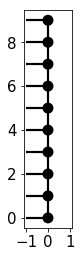

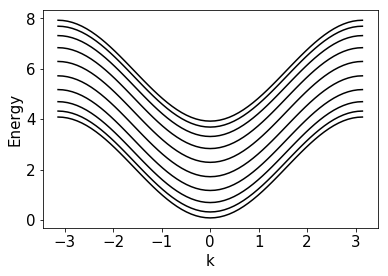

In [4]:
_lead = make_lead_x()
kwant.plot(_lead)
kwant.plotter.bands(_lead.finalized());

We see cosine-shaped bands that for low energies match the parabolic bands of the continuum model.  As expected (see previous notebook) the tight-binding approximation breaks down at high energies.

#### Your turn!
The next two cells are almost an identical copy of the previous two (The two changes are that the function got a different name and the lead is no longer plotted.) Your task is now to add one hopping that connects the first with the last site in y-direction, making the lead thus periodic in y-direction.  

So far, we only used ``lat.neighbors()`` to add hoppings to all lattice sites. We can also modify individual hoppings using

    sys[lat(x1, y1), lat(x2, y2)] = something
    
to set the hopping from $(x_2, y_2)$ to $(x_1, y_1)$ to ``something``.

Observe how the bands become degenerate.  Where does this degeneracy come from?

To see the degeneracy clearly, you may want to reduce the value of the “wrapped” hopping by a factor of, say, `0.8`.

In [5]:
def make_periodic_lead(W=10, t=1):
    syst = make_lead_x(W, t)
    #### Add periodic boundary conditions here.
    return syst

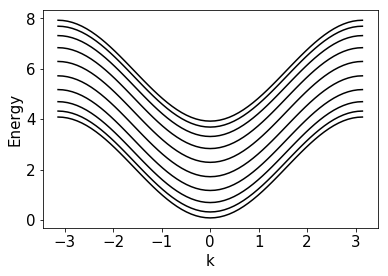

In [6]:
_lead = make_periodic_lead()
kwant.plotter.bands(_lead.finalized());

## Transmission through a quantum wire

Now we will use the method `attach_lead` of Kwant builders to attach infinite quasi-1d systems as leads to a finite system.

In [7]:
def make_wire(W=10, L=30, t=1):
    # Construct the scattering region.
    sr = kwant.Builder()
    sr[(lat(x, y) for x in range(L) for y in range(W))] = 4 * t
    sr[lat.neighbors()] = -t

    # Build and attach lead from both sides.
    lead = make_lead_x(W, t)
    sr.attach_lead(lead)
    sr.attach_lead(lead.reversed())

    return sr

The following function will plot transmission and reflection from lead 0 to lead 1 as a function of Fermi energy.

In [10]:
def plot_transmission(syst, energies):
    # Compute conductance
    trans = []
    refl = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        trans.append(smatrix.transmission(1, 0))
        refl.append(smatrix.transmission(0, 0))
    pyplot.plot(energies, trans, '.', c='r')
    pyplot.plot(energies, refl, 'o', c='b')

Let's now put the above functions to work by creating a system, plotting it, and then plotting transmission through it.  Since we have chosen the Hamiltonian of the scattering region (black dots) to be the same as in the leads, our system is still translationally invariant and there is no back-scattering: we see conductance steps that are characteristic of a clean quantum wire.  Compare the transmisison plot with the band structure plot above to verify that the steps occur whenever the Fremi energy reaches a new band.

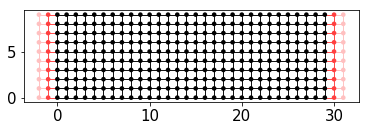

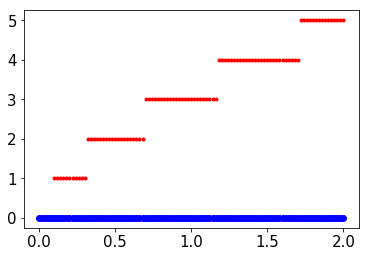

In [11]:
_wire = make_wire()
kwant.plot(_wire)
plot_transmission(_wire.finalized(), np.linspace(0, 2, 101))

#### Your turn!
Copy the previous cell below this one and modify `_wire` in some way, e.g. by removing one site.  Compare the transmission/reflection plot.

## Beyond the wire geometry

We are, of course, not restricted to a simplistic wire geometry.  Let's build a system that is a bit more complicated: a round quantum dot.

In [12]:
def make_dot(center, radius, t=1):
    def is_inside(pos):
        x, y = pos - center
        return x**2 + y**2 < rr

    rr = radius**2
    syst = kwant.Builder()
    syst[lat.shape(is_inside, center)] = 4 * t
    syst[lat.neighbors()] = -t

    return syst

First, execute the cell below as-is.  A round quantum dot is constructed and one x-directed lead attached to it.  Note how `attach_lead` added new sites to the scattering region to create a clean interface for the lead.  The Hamiltonian of these sites is taken from the lead that is being attached, such that the physics is unchanged.

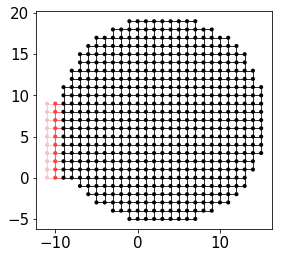

In [13]:
_dot = make_dot((3, 7), 13)
_dot.attach_lead(make_lead_x(10))
kwant.plot(_dot);
#### Attach the y-directed lead here.

#### Your turn!

As an exercise, let's add a second lead that is perpendicular to the first one.  Copy the cell that defines the function `make_lead_x` from the beginning of this notebook and paste it above this cell.  Use this as a base to define a function `make_lead_y`.  Then use this function in the cell below to attach a y-directed lead.

If you like, you can then calculate and plot transmission through the system.  You can simply reuse the function `plot_transmission`.

Of course, one can attach more than two leads to a scattering region.  For example, one could modify the previous cell to also attach the “reversed” versions of both leads (using ``sys.attach_lead(lead.reversed())``).

With more than two leads it becomes possible to do compute non-local conductances.  This is beyond the scope of this tutorial, but see the Kwant paper, and specifically the example `valve.py` in http://downloads.kwant-project.org/examples/kwant-examples-njp.zip.